## Set up

In [1]:
# mount google drive to see repository
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/github/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [2]:
!pip install -q onedrivedownloader

In [3]:
# basic needs
from onedrivedownloader import download
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import files

# custom utilities
from utils.mri_common import split_subjects, collate_scans, get_data_stats, normalize_collated_data, update_collated_stats, normalize_and_save, copy_segm_files
from utils.mri_plotter import plot_scan_stats

In [4]:
# seeding
random.seed(100)
np.random.seed(100)

In [5]:
# define global vars
DATA_DIR = "/content/data/"  # places this in colab runtime storage instead of gdrive
if not os.path.exists(DATA_DIR):
    !mkdir $DATA_DIR

# specify where to get the data
LATENT_SPACE_VECTORS_DIR = os.path.join(DATA_DIR, "latent_space_vectors")
LATENT_SPACE_VECTORS_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EVrWZoIYka9NgpECNhJvDmAB6D9WrMjh9x0mk59xl5Y8lg?e=KW6PS7"
LATENT_SPACE_VECTORS_FN = "latent_space_vectors.zip"

# Specify the scan types
STRUCT_SCANS = ['latent_vector_1', 'latent_vector_2', 'latent_vector_3']

# Output Dir
OUTPUT_DIR = '/content/data/latent_space_vectors_annot_reduced_norm'

# Reduced size files containing SEGM annotation masks
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "images_annot_reduced")
IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_FNAME = "images_annot_reduced.zip"

# download the reduced dataset if the files have not already been downloaded
if not os.path.exists(LATENT_SPACE_VECTORS_DIR):
    download(LATENT_SPACE_VECTORS_URL, filename=os.path.join(DATA_DIR, LATENT_SPACE_VECTORS_FN), unzip_path=LATENT_SPACE_VECTORS_DIR)
    download(IMAGES_ANNOT_REDUCED_URL, filename=os.path.join(DATA_DIR, IMAGES_ANNOT_REDUCED_FNAME), unzip_path=IMG_REDUCED_DIR)

100%|██████████| 1.30G/1.30G [00:46<00:00, 27.9MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 441/441 [00:10<00:00, 43.24it/s]
100%|██████████| 1.46G/1.46G [00:31<00:00, 46.4MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 736/736 [00:10<00:00, 70.42it/s]


The reduced dimensions data is unzipped into a nested folder structure. Fix that by moving the files up two levels and then remove the empty dirs

In [6]:
!mv /content/data/images_annot_reduced/data/images_annot_reduced/* /content/data/images_annot_reduced/

In [7]:
!rm -r /content/data/images_annot_reduced/data

## QC Input data

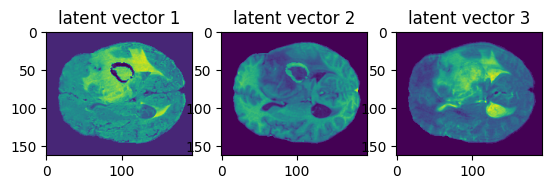

In [8]:
# test load and visualize subject UPENN-GBM-00002
upenn00002_lsv1 = nib.load(os.path.join(LATENT_SPACE_VECTORS_DIR, 'UPENN-GBM-00002_latent_vector_1.nii.gz'))
upenn00002_lsv2 = nib.load(os.path.join(LATENT_SPACE_VECTORS_DIR, 'UPENN-GBM-00002_latent_vector_2.nii.gz'))
upenn00002_lsv3 = nib.load(os.path.join(LATENT_SPACE_VECTORS_DIR, 'UPENN-GBM-00002_latent_vector_3.nii.gz'))

fig, axs = plt.subplots(ncols=3)
axs[0].imshow(upenn00002_lsv1.get_fdata()[:, :, 73])
axs[0].set_title('latent vector 1')
axs[1].imshow(upenn00002_lsv2.get_fdata()[:, :, 73])
axs[1].set_title('latent vector 2')
axs[2].imshow(upenn00002_lsv3.get_fdata()[:, :, 73])
axs[2].set_title('latent vector 3')
plt.show()

In [9]:
# get the shape of the image array data
SCAN_SHAPE = tuple(upenn00002_lsv1.header['dim'][1:4])
print(f"Scan shape: {SCAN_SHAPE}")

Scan shape: (163, 193, 146)


In [10]:
# obtain all images
# first, reduced dimensions data
reduced_files = os.listdir(IMG_REDUCED_DIR)
reduced_files.sort()
print(f"Number of reduced images : {len(reduced_files)}")
print(reduced_files[:10])

# second, latent space representations
latent_space_files = os.listdir(LATENT_SPACE_VECTORS_DIR)
latent_space_files.sort()
print(f"Number of latent space images : {len(latent_space_files)}")
print(latent_space_files[:10])

# obtain unique subjects
subjects = []
for my_file in latent_space_files:
    subjects.append(my_file.split('_')[0])
subjects = list(set(subjects))
subjects.sort()
print(f"Number of subjects: {len(subjects)}")
print(subjects[:10])

# extract the subject scan for the first manually-revised segmentation label e.g. UPENN-GBM-00002_11
subj_file = subjects[0]
print('Example subject ID:', subj_file)

Number of reduced images : 735
['UPENN-GBM-00002_11_FLAIR_cut.nii.gz', 'UPENN-GBM-00002_11_T1GD_cut.nii.gz', 'UPENN-GBM-00002_11_T1_cut.nii.gz', 'UPENN-GBM-00002_11_T2_cut.nii.gz', 'UPENN-GBM-00002_11_segm_cut.nii.gz', 'UPENN-GBM-00006_11_FLAIR_cut.nii.gz', 'UPENN-GBM-00006_11_T1GD_cut.nii.gz', 'UPENN-GBM-00006_11_T1_cut.nii.gz', 'UPENN-GBM-00006_11_T2_cut.nii.gz', 'UPENN-GBM-00006_11_segm_cut.nii.gz']
Number of latent space images : 441
['UPENN-GBM-00002_latent_vector_1.nii.gz', 'UPENN-GBM-00002_latent_vector_2.nii.gz', 'UPENN-GBM-00002_latent_vector_3.nii.gz', 'UPENN-GBM-00006_latent_vector_1.nii.gz', 'UPENN-GBM-00006_latent_vector_2.nii.gz', 'UPENN-GBM-00006_latent_vector_3.nii.gz', 'UPENN-GBM-00008_latent_vector_1.nii.gz', 'UPENN-GBM-00008_latent_vector_2.nii.gz', 'UPENN-GBM-00008_latent_vector_3.nii.gz', 'UPENN-GBM-00009_latent_vector_1.nii.gz']
Number of subjects: 147
['UPENN-GBM-00002', 'UPENN-GBM-00006', 'UPENN-GBM-00008', 'UPENN-GBM-00009', 'UPENN-GBM-00011', 'UPENN-GBM-00013'

As expected &check;

## Split into Train, Val, Test

In [11]:
train_list, reserve_list = split_subjects(subjects, split_ratio=0.6, seed=2023)
val_list, test_list = split_subjects(reserve_list, split_ratio=0.5, seed=2023)

# QC
print(len(train_list))
print(len(val_list))
print(len(test_list))
print(len(subjects) == (len(train_list) + len(val_list) + len(test_list)))

88
30
29
True


## Cube statistics and normalization test

In [10]:
# collate all the images together into a single array
# note: this is memory intensive so use the High-Memory runtime
collated_img = collate_scans(
    subject_list=subjects,
    shape=SCAN_SHAPE,
    struct_scan_list=STRUCT_SCANS,
    scan_type='latent_vector',
    data_path=LATENT_SPACE_VECTORS_DIR
)

Working on subject no: 1 / 147
Working on subject no: 2 / 147
Working on subject no: 3 / 147
Working on subject no: 4 / 147
Working on subject no: 5 / 147
Working on subject no: 6 / 147
Working on subject no: 7 / 147
Working on subject no: 8 / 147
Working on subject no: 9 / 147
Working on subject no: 10 / 147
Working on subject no: 11 / 147
Working on subject no: 12 / 147
Working on subject no: 13 / 147
Working on subject no: 14 / 147
Working on subject no: 15 / 147
Working on subject no: 16 / 147
Working on subject no: 17 / 147
Working on subject no: 18 / 147
Working on subject no: 19 / 147
Working on subject no: 20 / 147
Working on subject no: 21 / 147
Working on subject no: 22 / 147
Working on subject no: 23 / 147
Working on subject no: 24 / 147
Working on subject no: 25 / 147
Working on subject no: 26 / 147
Working on subject no: 27 / 147
Working on subject no: 28 / 147
Working on subject no: 29 / 147
Working on subject no: 30 / 147
Working on subject no: 31 / 147
Working on subjec

In [11]:
# calculate raw stats
raw_stats_arr = get_data_stats(
    collated_img,
    subject_list=subjects,
    struct_scan_list=STRUCT_SCANS,
    scan_type='latent_vector',
    data_path=LATENT_SPACE_VECTORS_DIR
)

Working on Subject No: 1 / 147
Working on Subject No: 2 / 147
Working on Subject No: 3 / 147
Working on Subject No: 4 / 147
Working on Subject No: 5 / 147
Working on Subject No: 6 / 147
Working on Subject No: 7 / 147
Working on Subject No: 8 / 147
Working on Subject No: 9 / 147
Working on Subject No: 10 / 147
Working on Subject No: 11 / 147
Working on Subject No: 12 / 147
Working on Subject No: 13 / 147
Working on Subject No: 14 / 147
Working on Subject No: 15 / 147
Working on Subject No: 16 / 147
Working on Subject No: 17 / 147
Working on Subject No: 18 / 147
Working on Subject No: 19 / 147
Working on Subject No: 20 / 147
Working on Subject No: 21 / 147
Working on Subject No: 22 / 147
Working on Subject No: 23 / 147
Working on Subject No: 24 / 147
Working on Subject No: 25 / 147
Working on Subject No: 26 / 147
Working on Subject No: 27 / 147
Working on Subject No: 28 / 147
Working on Subject No: 29 / 147
Working on Subject No: 30 / 147
Working on Subject No: 31 / 147
Working on Subjec

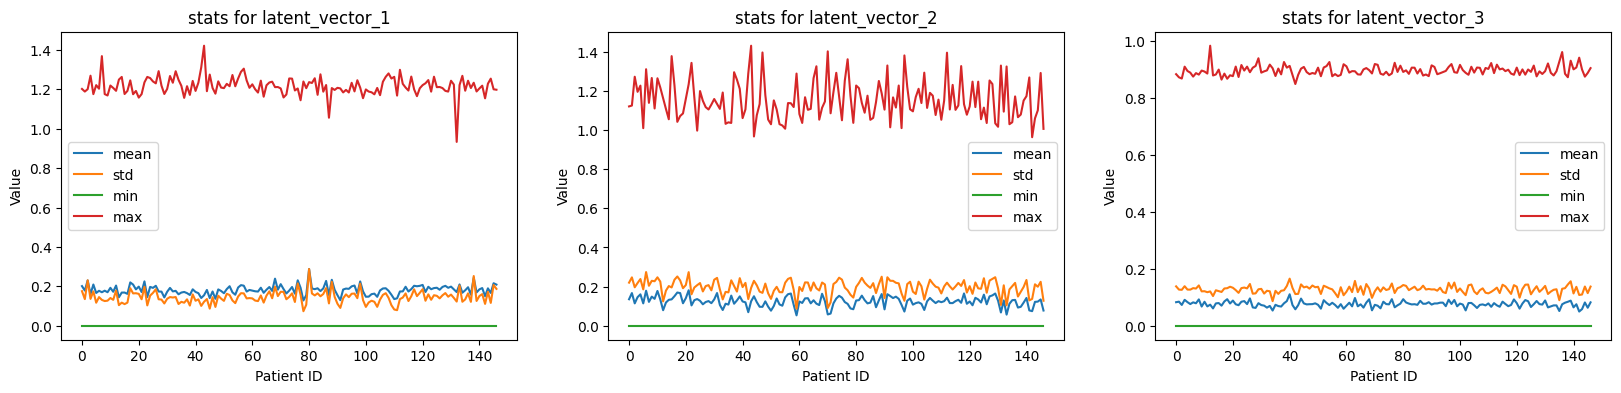

In [12]:
# plot the raw statistics
plot_scan_stats(
    raw_stats_arr,
    STRUCT_SCANS,
)

In [13]:
# what is the min of the mins?
raw_stats_arr[:, :, 2].min()

0.0

In [14]:
# normalize the collated images
normalize_collated_data(
    collated_img,
    raw_stats_arr,
    subjects,
    STRUCT_SCANS
)

Working on Subject No: 1 / 147
Working on Subject No: 2 / 147
Working on Subject No: 3 / 147
Working on Subject No: 4 / 147
Working on Subject No: 5 / 147
Working on Subject No: 6 / 147
Working on Subject No: 7 / 147
Working on Subject No: 8 / 147
Working on Subject No: 9 / 147
Working on Subject No: 10 / 147
Working on Subject No: 11 / 147
Working on Subject No: 12 / 147
Working on Subject No: 13 / 147
Working on Subject No: 14 / 147
Working on Subject No: 15 / 147
Working on Subject No: 16 / 147
Working on Subject No: 17 / 147
Working on Subject No: 18 / 147
Working on Subject No: 19 / 147
Working on Subject No: 20 / 147
Working on Subject No: 21 / 147
Working on Subject No: 22 / 147
Working on Subject No: 23 / 147
Working on Subject No: 24 / 147
Working on Subject No: 25 / 147
Working on Subject No: 26 / 147
Working on Subject No: 27 / 147
Working on Subject No: 28 / 147
Working on Subject No: 29 / 147
Working on Subject No: 30 / 147
Working on Subject No: 31 / 147
Working on Subjec

In [15]:
# calculate new stats
updated_stats_arr = update_collated_stats(
    collated_img,
    subjects,
    STRUCT_SCANS
)

Working on Subject No: 1 / 147
Working on Subject No: 2 / 147
Working on Subject No: 3 / 147
Working on Subject No: 4 / 147
Working on Subject No: 5 / 147
Working on Subject No: 6 / 147
Working on Subject No: 7 / 147
Working on Subject No: 8 / 147
Working on Subject No: 9 / 147
Working on Subject No: 10 / 147
Working on Subject No: 11 / 147
Working on Subject No: 12 / 147
Working on Subject No: 13 / 147
Working on Subject No: 14 / 147
Working on Subject No: 15 / 147
Working on Subject No: 16 / 147
Working on Subject No: 17 / 147
Working on Subject No: 18 / 147
Working on Subject No: 19 / 147
Working on Subject No: 20 / 147
Working on Subject No: 21 / 147
Working on Subject No: 22 / 147
Working on Subject No: 23 / 147
Working on Subject No: 24 / 147
Working on Subject No: 25 / 147
Working on Subject No: 26 / 147
Working on Subject No: 27 / 147
Working on Subject No: 28 / 147
Working on Subject No: 29 / 147
Working on Subject No: 30 / 147
Working on Subject No: 31 / 147
Working on Subjec

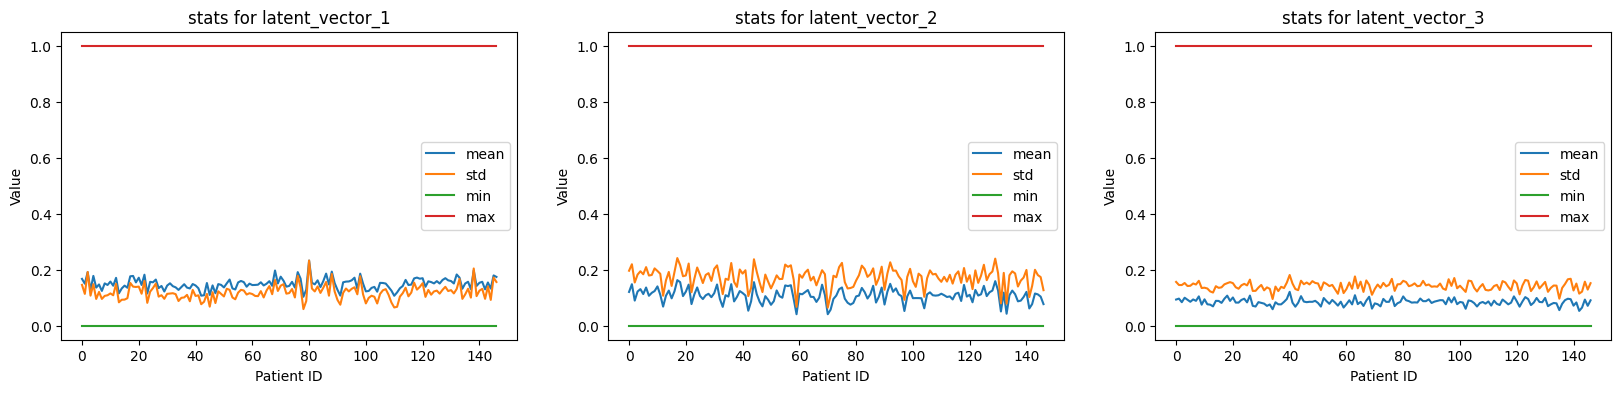

In [16]:
# plot the updated stats
plot_scan_stats(
    updated_stats_arr,
    STRUCT_SCANS
)

## Normalize and Output 3D cubes

In [12]:
normalize_and_save(
    subjects_list=subjects,
    struct_scan_list=STRUCT_SCANS,
    data_dir=LATENT_SPACE_VECTORS_DIR,
    output_dir=OUTPUT_DIR
)

Working on subject no: 1 / 147
Working on subject no: 2 / 147
Working on subject no: 3 / 147
Working on subject no: 4 / 147
Working on subject no: 5 / 147
Working on subject no: 6 / 147
Working on subject no: 7 / 147
Working on subject no: 8 / 147
Working on subject no: 9 / 147
Working on subject no: 10 / 147
Working on subject no: 11 / 147
Working on subject no: 12 / 147
Working on subject no: 13 / 147
Working on subject no: 14 / 147
Working on subject no: 15 / 147
Working on subject no: 16 / 147
Working on subject no: 17 / 147
Working on subject no: 18 / 147
Working on subject no: 19 / 147
Working on subject no: 20 / 147
Working on subject no: 21 / 147
Working on subject no: 22 / 147
Working on subject no: 23 / 147
Working on subject no: 24 / 147
Working on subject no: 25 / 147
Working on subject no: 26 / 147
Working on subject no: 27 / 147
Working on subject no: 28 / 147
Working on subject no: 29 / 147
Working on subject no: 30 / 147
Working on subject no: 31 / 147
Working on subjec

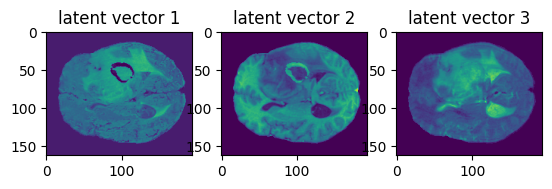

In [13]:
# test load and visualize
upenn00002_lsv1 = nib.load(os.path.join(OUTPUT_DIR, 'UPENN-GBM-00002_11_latent_vector_1.nii.gz'))
upenn00002_lsv2 = nib.load(os.path.join(OUTPUT_DIR, 'UPENN-GBM-00002_11_latent_vector_2.nii.gz'))
upenn00002_lsv3 = nib.load(os.path.join(OUTPUT_DIR, 'UPENN-GBM-00002_11_latent_vector_3.nii.gz'))

fig, axs = plt.subplots(ncols=3)
axs[0].imshow(upenn00002_lsv1.get_fdata()[:, :, 73], vmin=0, vmax=1)
axs[0].set_title('latent vector 1')
axs[1].imshow(upenn00002_lsv2.get_fdata()[:, :, 73], vmin=0, vmax=1)
axs[1].set_title('latent vector 2')
axs[2].imshow(upenn00002_lsv3.get_fdata()[:, :, 73], vmin=0, vmax=1)
axs[2].set_title('latent vector 3')
plt.show()

Looks good &check;

In [14]:
# copy the associated SEGM annotation masks into OUTPUT_DIR
copy_segm_files(OUTPUT_DIR, IMG_REDUCED_DIR)

Zip the files together and download

In [15]:
!zip /content/data/latent_space_vectors_annot_reduced_norm.zip /content/data/latent_space_vectors_annot_reduced_norm/*

  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00002_11_latent_vector_1.nii.gz (deflated 1%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00002_11_latent_vector_2.nii.gz (deflated 1%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00002_11_latent_vector_3.nii.gz (deflated 1%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00002_11_segm.nii.gz (deflated 21%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00006_11_latent_vector_1.nii.gz (deflated 1%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00006_11_latent_vector_2.nii.gz (deflated 0%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00006_11_latent_vector_3.nii.gz (deflated 1%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN-GBM-00006_11_segm.nii.gz (deflated 37%)
  adding: content/data/latent_space_vectors_annot_reduced_norm/UPENN